In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy
import netgraph
import seaborn as sns
import scipy.stats
import replicate
from utils import get_response, summarize_reasons

MEDIUM_SIZE = 26
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def network_growth(n0, temperature, model, environment, role, method='llm', num_common_neighbors=True):

    if method == 'sbm':
        G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]])
   
        return [G], []  
    else:
        G = nx.stochastic_block_model([n0 // 2, n0 // 2], [[0.5, 0.1], [0.1, 0.5]], seed=0)


    Gs = []
    results = []

    for t in G.nodes():

        if method == 'llm':
            result = select_neighbor(G, t, temperature, num_common_neighbors=num_common_neighbors, model=model, environment=environment, role=role)
            if result:
                v = result['name']
                G.add_edge(t, v)
                results.append(result)
        elif method == 'random':
            v = random.choice(list(set(G.nodes() - set(G.neighbors(t)))))
            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'random'})
        elif method == 'winner':
            v = None,
            max_common_friends = 0
            for u in G.nodes():
                if u not in G.neighbors(t) and u != t and len(set(G.neighbors(u)) & set(G.neighbors(t))) > max_common_friends:
                    v = u
                    max_common_friends = len(set(G.neighbors(u)) & set(G.neighbors(t)))

            G.add_edge(t, v)
            results.append({'name' : v, 'common_friends' : list(set(G.neighbors(v)) & set(G.neighbors(t))), 'reason' : 'winner'})

        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature, model, environment, role, num_common_neighbors=True):
    
    candidate_profiles = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            if num_common_neighbors:
                candidate_profiles.append({'name' : v, 'common_friends' : len(set(G.neighbors(v)) & set(G.neighbors(t)))})
            else:
                candidate_profiles.append({'name' : v, 'friends' : list(G.neighbors(v))})

    prompt = f"""
    # Task
    {f'You are in a {environment}.' if environment else ''}Your task is to select a person to be {role} with.

    # Input
    The input is a list of dictionaries. 
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps({'name' : t, 'friends' : list(G.neighbors(t))})}
    </PROFILE>

    The list of candidate profiles is given below after chevrons:
    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}

    # Notes
    * The name of the person you selected must be one of the names in the input.
    * Your output must be JSON only.

    ```json
    """   

    for i in range(10):
        try:
            ans = get_response(prompt, temperature=temperature, system_prompt="You are a helpful assistant", model=model)

            try:
                result = json.loads(ans.split('```')[0])
            except:
                result = json.loads(ans.split('```json')[1].split('```')[0])

            if result['name'] in G.nodes():    
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
    
def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method, model, environment=None, role='friends', num_common_neighbors=True):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method, num_common_neighbors=num_common_neighbors, model=model, environment=environment, role=role)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None, use_netgraph=True):
    group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
    group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]
    
    if not G0:
        G0_edges = set()
    else:
        G0_edges = set(G0.edges())
    G_edges = set(G.edges()) - G0_edges

    G_group_1 = (set(nx.subgraph(G, group_1).edges()) & G_edges) - G0_edges
    G0_group_1 = (set(nx.subgraph(G0, group_1).edges()))
    G_group_2 = (set(nx.subgraph(G, group_2).edges()) & G_edges) - G0_edges
    G0_group_2 = set(nx.subgraph(G0, group_2).edges())
    G_between = G_edges - set(nx.subgraph(G, group_1).edges()) - set(nx.subgraph(G, group_2).edges()) - G0_edges
    G0_between = G0_edges - set(nx.subgraph(G0, group_1).edges()) - set(nx.subgraph(G0, group_2).edges())
    pos = nx.spring_layout(G)

    if not use_netgraph:
       
        node_color = ['#c0392b' if n in group_1 else '#2980b9' for n in G.nodes()]

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=0.5, node_color=node_color, alpha=0.7, edge_color='#34495e')
        else:
            
            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=0.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_between, width=1.0, alpha=1, edge_color='#f1c40f', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_group_1, width=2, alpha=1, edge_color='#c0392b', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G0_group_1, width=1.0, alpha=0.5, edge_color='#e74c3c', ax=ax)

            nx.draw_networkx_edges(G, pos, edgelist=G_group_2, width=2, alpha=1, edge_color='#2980b9', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G0_group_2, width=1.0, alpha=0.5, edge_color='#3498db', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=node_color, alpha=0.7, ax=ax)
    else:
        node2community = {i: 0 if i < len(G.nodes()) // 2 else 1 for i in G.nodes()}
        node_color = {i : '#c0392b' if node2community[i] == 0 else  '#2980b9' for i in G.nodes()}

        edge_color = {}
        edge_width = {}
        edge_alpha = {}
        for (u, v) in G.edges():
            if (u, v) in G_group_1:
                edge_color[u, v] = '#c0392b'
            elif (u, v) in G_group_2:
                edge_color[u, v] = '#2980b9'
            elif (u, v) in G0_group_1:
                edge_color[u, v] = '#e74c3c'
            elif (u, v) in G0_group_2:
                edge_color[u, v] = '#3498db'
            elif (u, v) in G_between:
                edge_color[u, v] = '#f1c40f'
            else:
                edge_color[u, v] = '#bdc3c7'

            if (u, v) in G_group_1 or (u, v) in G_group_2 or (u, v) in G_between:
                edge_width[u, v] = 2
                edge_alpha[u, v] = 1
            else:
                edge_width[u, v] = 1
                edge_alpha[u, v] = 0.5

        # netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_color=edge_color, edge_layout='bundled', edge_layout_kwargs=dict(k=2000), ax=ax)
        netgraph.Graph(G, node_layout=pos, node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_color=edge_color, edge_width=edge_width, edge_alpha=edge_alpha, ax=ax)


    ax.set_axis_off()

def prob_edge_wihin_community(G, G0):
    group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
    group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]
    
    G0_edges = set(G0.edges())

    G_edges = set(G.edges()) - G0_edges

    G_between = G_edges - set(nx.subgraph(G, group_1).edges()) - set(nx.subgraph(G, group_2).edges()) - G0_edges

    try:
        return 1 - len(G_between) / len(G_edges)
    except:
        return 0

def analyze_experiments(filename, num_common_neighbors=True):

    suffix = os.path.split(os.path.splitext(filename)[0])[-1]

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    transitivities = collections.defaultdict(list)
    algebraic_connectivities = collections.defaultdict(list)
    probabilities_of_edge_within_community = collections.defaultdict(list)
    # partition_qualitys = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            G.remove_edges_from(nx.selfloop_edges(G))

            Gs.append(G)

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))

        fig.suptitle(f'Temperature = {d["temperature"]}')

        for i, t in enumerate([0, len(Gs) // 2, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            draw_graph(G, ax=ax[i], G0=Gs[0])

            # print(d['reasons'])

        group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
        group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]


        final_graphs[d['n'], d['temperature']].append((Gs[-1], Gs[0]))

        initial_transitivity = nx.transitivity(Gs[0])

        transitivity = [nx.transitivity(G) - initial_transitivity for G in Gs]

        algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

        probability_of_edge_within_community = [prob_edge_wihin_community(G, Gs[0]) for G in Gs[1:]]

        # partition_quality = [nx.community.partition_quality(G, communities)[0] for G in Gs]

        # ax[-1].set_title('Metrics')
        ax[-1].plot(transitivity, label='Marginal Transitivity', color='#c0392b')

        ax_y = ax[-1].twinx()

        ax_y.plot(algebraic_connectivity, label='Algebraic Connectivity', color='#2980b9')
        ax[-1].set_xlabel('t')
        ax[-1].set_ylabel('Transitivity', color='#c0392b')
        ax_y.set_ylabel('Algebraic Connectivity', color='#2980b9')

        transitivities[d['n'], d['temperature']].append(transitivity)
        algebraic_connectivities[d['n'], d['temperature']].append(algebraic_connectivity)
        probabilities_of_edge_within_community[d['n'], d['temperature']].append(probability_of_edge_within_community)
        # partition_qualitys[d['n'], d['temperature']].append(partition_quality)

        fig.tight_layout()
        fig.savefig(f'figures/principle_2/{suffix}_{d["n"]}_{d["simulation"]}_{d["temperature"]}{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)

    palette = ['#e67e22', '#f1c40f', '#7f8c8d', '#c0392b', '#2980b9', '#34495e']


    fig, ax = plt.subplots(4, len(transitivities), figsize=(5 * len(transitivities), 10), squeeze=False, sharey='row')

    fig_combined, ax_combined = plt.subplots(1, 3, figsize=(10, 5), squeeze=False)

    ax_combined[0, 0].set_ylabel('Transitivity')
    ax_combined[0, 1].set_ylabel('Algebraic Connectivity')
    ax_combined[0, 2].set_ylabel('Probability of Edge within Community')
    # ax_combined[0, 3].set_ylabel('Partition Quality')
    ax_combined[0, 0].set_xlabel('t')
    ax_combined[0, 1].set_xlabel('t')
    ax_combined[0, 2].set_xlabel('t')
    # ax_combined[0, 3].set_xlabel('t')

    ax_combined[0, 0].set_xlim(0, 49)
    ax_combined[0, 1].set_xlim(0, 49)
    ax_combined[0, 2].set_xlim(0, 49)
    # ax_combined[0, 3].set_xlim(0, 49)

    fig_final, ax_final = plt.subplots(1, len(final_graphs) + 2, figsize=(5 * (2 + len(final_graphs)), 5), squeeze=False, gridspec_kw={'width_ratios': [1] * len(final_graphs) + [0.5, 0.5]})

    ax_final[0, -1].spines[['right', 'top']].set_visible(False)
    ax_final[0, -2].spines[['right', 'top']].set_visible(False)



    for i, (k, v) in enumerate(sorted(final_graphs.items())):
        G, G0 = v[0]
        draw_graph(G, ax=ax_final[0, i], G0=G0)

        ax_final[0, i].set_title(f'Temperature = {k[1]}')


    # ax_final[0, -1].set_ylabel('Algebraic Connectivity')
    # ax_final[0, -1].set_xticks([])

    ax_final[0, -2].set_ylabel('Marginal Transitivity')
    ax_final[0, -2].set_xticks([])
        
    ax_final[0, -1].set_ylabel('Pr. of Edge within Community')
    ax_final[0, -1].set_xticks([])

    for i, (k, c) in enumerate(zip(sorted(transitivities.keys()), palette)):
        v = transitivities[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))

        ax[0, i].plot(mean, color='#2980b9', label='LLM')
        ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')

        ax[0, i].set_title(f'Temperature = {k[1]}')

        ax[0, i].set_xlabel('t')

        if i == 0:
            ax[0, i].set_ylabel('Marginal Transitivity')

        ax[0, i].set_ylim(0.35, 0.5)

        ax[0, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 0].plot(mean, color=c, label='Temp = ' + str(k[1]))
        ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

        ax_final[0, -2].bar(i, mean[-1], color=palette[i], alpha=0.6, label='Temp = ' + str(k[1]))
        ax_final[0, -2].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=1)

    ax_combined[0, 0].set_ylim(0.35, 0.5)


    for i, (k, c) in enumerate(zip(sorted(algebraic_connectivities.keys()), palette)):
        v = algebraic_connectivities[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))


        ax[1, i].plot(mean, color='#2980b9', label='LLM')
        ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')
        ax[1, i].set_ylim(3.5, 6)

        ax[1, i].set_xlim(0, len(mean) - 1)

        if i == 0:
            ax[1, i].set_ylabel('Algebraic Connectivity')

        ax_combined[0, 1].plot(mean, color=c, label='Temp = ' + str(k[1]))
        ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

        # ax_final[0, -1].bar(i, mean[-1], color=palette[i], alpha=0.5, label='Temp = ' + str(k[1]))
        # ax_final[0, -1].errorbar(i, mean[-1], yerr=ci[-1], color=palette[i], alpha=0.5)

    for i, (k, c) in enumerate(zip(sorted(probabilities_of_edge_within_community.keys()), palette)):
        v = probabilities_of_edge_within_community[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))

        # ax[2, i].plot(mean, color='#2980b9', label='LLM')
        # ax[2, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')

        # ax[2, i].set_title(f'Temperature = {k[1]}')

        # ax[2, i].set_xlabel('t')

        # if i == 0:
        #     ax[2, i].set_ylabel('Probability of Edge within Community')

        # ax[2, i].set_ylim(0.35, 0.5)

        # ax[2, i].set_xlim(0, len(mean) - 1)

        # ax_combined[0, 2].plot(mean, color=c, label='Temp = ' + str(k[1]))
        # ax_combined[0, 2].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

        ax_final[0, -1].bar(i, mean[-1], color=palette[i], alpha=0.5, label='Temp = ' + str(k[1]))
        ax_final[0, -1].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=0.5)

    # for i, (k, c) in enumerate(zip(sorted(partition_qualitys.keys()), palette)):
    #     v = partition_qualitys[k]
    #     v = np.array(v)

    #     mean = v.mean(axis=0)
    #     std = v.std(axis=0)

    #     ci = 1.96 * std / np.sqrt(len(v))

    #     # ax[2, i].plot(mean, color='#2980b9', label='LLM')
    #     # ax[2, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#2980b9')

    #     # ax[2, i].set_title(f'Temperature = {k[1]}')

    #     # ax[2, i].set_xlabel('t')

    #     # if i == 0:
    #     #     ax[2, i].set_ylabel('Probability of Edge within Community')

    #     # ax[2, i].set_ylim(0.35, 0.5)

    #     # ax[2, i].set_xlim(0, len(mean) - 1)

    #     # ax_combined[0, 2].plot(mean, color=c, label='Temp = ' + str(k[1]))
    #     # ax_combined[0, 2].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

    #     ax_final[0, -2].bar(i, mean[-1], color=palette[i], alpha=0.5, label='Temp = ' + str(k[1]))
    #     ax_final[0, -2].errorbar(i, mean[-1], yerr=ci[-1], color='black', alpha=0.5)

    ax_combined[0, 2].set_ylim(0, 1)

    # Null models
    transitivities_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }
    algebraic_connectivities_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }
    probabilities_of_edge_within_community_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list), 'sbm' : collections.defaultdict(list) }
    # partition_qualitys_null = { 'random' : collections.defaultdict(list), 'winner' : collections.defaultdict(list) }

    for d in data:
        for method in ['random']:
            Gs, _ = network_growth(d['n'], d['temperature'], method=method)

            initial_transitivity = nx.transitivity(Gs[0])

            transitivity = [nx.transitivity(G) - initial_transitivity for G in Gs]

            transitivities_null[method][d['n'], d['temperature']].append(transitivity)


            algebraic_connectivity = [nx.algebraic_connectivity(G) for G in Gs]

            algebraic_connectivities_null[method][d['n'], d['temperature']].append(algebraic_connectivity)

            group_1 = [n for n in G.nodes() if n < len(G.nodes()) // 2]
            group_2 = [n for n in G.nodes() if n >= len(G.nodes()) // 2]

            communities = [group_1, group_2]

            probability_of_edge_within_community = [prob_edge_wihin_community(G, Gs[0]) for G in Gs[1:]]

            probabilities_of_edge_within_community_null[method][d['n'], d['temperature']].append(probability_of_edge_within_community)

            # partition_quality = [nx.algorithms.community.partition_quality(G, communities)[0] for G in Gs]
            # partition_qualitys_null[method][d['n'], d['temperature']].append(partition_quality)
    

    for j, method in enumerate(['random']):
        for i, (k, v) in enumerate(transitivities_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            ax[0, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')

            if i == 0:
                ax_combined[0, 0].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
                ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')

            if i == 0:
                ax_final[0, -2].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
                ax_final[0, -2].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)
            
            print('Transitivity T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in transitivities[k]], [x[-1] for x in transitivities_null[method][k]], equal_var=False))

        for i, (k, v) in enumerate(algebraic_connectivities_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            ax[1, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')
            if i == 0:
                ax_combined[0, 1].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
                ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e', hatch='||')

            # if i == 0:
            #     ax_final[0, -1].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.2, label=method.capitalize())
            #     ax_final[0, -1].errorbar(j + 3, mean[-1], yerr=ci[-1], color=palette[j+3], alpha=0.5)

            print('Algebraic Connectivity T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in algebraic_connectivities[k]], [x[-1] for x in algebraic_connectivities_null[method][k]], equal_var=False))

        for i, (k, v) in enumerate(probabilities_of_edge_within_community_null[method].items()):
            

            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            ax[1, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
            ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')
            if i == 0:
                ax_combined[0, 2].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
                ax_combined[0, 2].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e', hatch='||')

            if i == 0:                
                ax_final[0, -1].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
                ax_final[0, -1].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)

            print('Probability of edge within community T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in probabilities_of_edge_within_community[k]], [x[-1] for x in probabilities_of_edge_within_community_null[method][k]], equal_var=False))

        # for i, (k, v) in enumerate(probabilities_of_edge_within_community_null[method].items()):
        #     v = np.array(v)

        #     mean = v.mean(axis=0)
        #     std = v.std(axis=0)

        #     ci = 1.96 * std / np.sqrt(len(v))

        #     ax[1, i].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':', label=method.capitalize())
        #     ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e')
        #     if i == 0:
        #         ax_combined[0, 3].plot(mean, color='#c0392b' if method == 'random' else '#34495e', linestyle='--' if method == 'random' else ':')
        #         ax_combined[0, 3].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#c0392b' if method == 'random' else '#34495e', hatch='||')

        #     if i == 0:
        #         ax_final[0, -2].bar(j + 3, mean[-1], color=palette[j+3], alpha=0.6, label=method.capitalize())
        #         ax_final[0, -2].errorbar(j + 3, mean[-1], yerr=ci[-1], color='black', alpha=1)

        #     print('Partition Quality T-test', k, method, scipy.stats.ttest_ind([x[-1] for x in partition_qualitys[k]], [x[-1] for x in partition_qualitys_null[method][k]], equal_var=False))

    ax_final[0, -1].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    ax[0, 0].legend(loc='upper left')
    ax[1, 0].legend(loc='upper left')

    ax_combined[0, 0].legend(loc='upper left')
    # ax_combined[0, 1].legend(loc='upper left')

    fig_combined.tight_layout()

    fig.tight_layout()

    fig.savefig(f'figures/principle_2/{suffix}_overall{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)

    fig_combined.savefig(f'figures/principle_2/{suffix}_overall_combined{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)
     

    fig_final.tight_layout()

    fig_final.savefig(f'figures/principle_2/{suffix}_final{"_neighbors" if not num_common_neighbors else ""}.png', dpi=300)


def get_table(filenames):

    records = []

    num_graphs = 0

    for filename in filenames:
        print(filename)
        suffix = os.path.split(os.path.splitext(filename)[0])[-1]
        suffix = suffix.split('+')

        if len(suffix) == 3:
            model = suffix[-2]
            environment = suffix[-1]
        elif len(suffix) == 2:
            model = suffix[-1]
            environment = 'Baseline'
        else:
            environment = 'Baseline'

        with open(filename) as f:
            lines = f.read().splitlines()

        data = []

        for line in lines:
            data.append(json.loads(line))

        for d in data:
            Gs = []
            for graph in d['graphs']:
                G = nx.Graph()

                for k, v in graph.items():
                    k = int(k)
                    G.add_node(k)
                    for n in v:
                        G.add_edge(k, n)

                G.remove_edges_from(nx.selfloop_edges(G))

                Gs.append(G)


            initial_transitivity = nx.transitivity(Gs[0])
            final_transitivity = nx.transitivity(Gs[-1])
            marginal_transitivity = final_transitivity - initial_transitivity
            # final_algebraic_connectivity = nx.algebraic_connectivity(Gs[-1])
            final_probability_of_edge_within_community = prob_edge_wihin_community(Gs[-1], Gs[1])

            
            record = {
                'Model' : model,
                'Environment' : environment,
                'Temperature' : d['temperature'],
                'Marginal Transitivity' : marginal_transitivity,
                # 'Algebraic Connectivity' : final_algebraic_connectivity,
                'Prob. of Edge within Community' : final_probability_of_edge_within_community,
            }

            records.append(record)

            Gs_random, _ = network_growth(d['n'], d['temperature'], method='random', model='', environment=None, role='friends')

            initial_transitivity_random = nx.transitivity(Gs_random[0])
            final_transitivity_random = nx.transitivity(Gs_random[-1])
            marginal_transitivity_random = final_transitivity_random - initial_transitivity_random
            # final_algebraic_connectivity_random = nx.algebraic_connectivity(Gs_random[-1])
            final_probability_of_edge_within_community_random = prob_edge_wihin_community(Gs_random[-1], Gs_random[1])

            record_random = {
                'Temperature' : d['temperature'],
                'Model' : 'Random',
                'Environment' : None,
                'Marginal Transitivity' : marginal_transitivity_random,
                # 'Algebraic Connectivity' : final_algebraic_connectivity_random,
                'Prob. of Edge within Community' : final_probability_of_edge_within_community_random,
            }

            records.append(record_random)

    df = pd.DataFrame(records)

    # average over simulations
    df_groupped = df.groupby(['Model', 'Environment', 'Temperature']).mean().reset_index()

    # do t-test with random
    for temperature in df['Temperature'].unique():
        for metric in ['Marginal Transitivity',  'Prob. of Edge within Community']:
            for model in df['Model'].unique():
                if model == 'Random' and 'Temperature' == -1:
                    continue
                data = df[(df['Temperature'] == temperature) & (df['Model'] == model)][metric].values
                data_random = df[(df['Temperature'] == temperature) & (df['Model'] == 'Random')][metric].values

                t, p = scipy.stats.ttest_ind(data, data_random, equal_var=False)

                # Get stars
                if p < 0.001:
                    p = '***'
                elif p < 0.01:
                    p = '**'
                elif p < 0.05:
                    p = '*'
                else:
                    p = ''

                if p != '':
                    df_groupped.loc[(df_groupped['Temperature'] == temperature) & (df_groupped['Model'] == model), metric] = f'{df_groupped.loc[(df_groupped["Temperature"] == temperature) & (df_groupped["Model"] == model), metric].values[0]:.3f} ({p})'


    df_groupped.sort_values(['Model', 'Environment', 'Temperature'], inplace=True)

    df_groupped.to_csv('tables/principle_2.csv', index=False)
    df_groupped.to_latex('tables/principle_2.tex', index=False, escape=False, float_format="%.3f")


    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3-70b',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5 Sonnet',
    }

    rename_env = {
        'school' : 'Sch',
        'work' : 'Wrk',
        'community' : 'Cmn',
    }


    df['Model'] = df['Model'].apply(lambda x: rename_models.get(x, x))

    df_baseline = df[df['Environment'] == 'Baseline']
    df_baseline = df_baseline[df_baseline['Model'] != 'Random']

    df_nonbaseline = df[df['Environment'] != 'Baseline']
    df_nonbaseline['Environment'] = df_nonbaseline['Environment'].apply(lambda x: rename_env.get(x, x))

    fig, ax = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [3, 1]})

    step = 0.1
    num_models = len(df_baseline['Model'].unique())

    # add a different jitter for each model to avoid overlapping points
    # for i, model in enumerate(df_baseline['Model'].unique()):
    #     df_baseline.loc[df_baseline['Model'] == model, 'Temperature'] = df_baseline.loc[df_baseline['Model'] == model, 'Temperature'] + step * (i - num_models // 2)

    num_environments = len(df_nonbaseline['Environment'].unique())

    # for i, environment in enumerate(df_nonbaseline['Environment'].unique()):
    #     df_nonbaseline.loc[df_nonbaseline['Environment'] == environment, 'Temperature'] = 2 + step * (i - num_environments // 2)

    temp_min = df_baseline['Temperature'].min() - 0.25
    temp_max = 2.25
    df_random = df[df['Model'] == 'Random']
    
    for i, y in enumerate(['Marginal Transitivity', 'Prob. of Edge within Community']):

        sns.boxplot(data=df_baseline, y=y, x="Temperature", hue="Model", palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], ax=ax[i, 0])
        # sns.stripplot(data=df_baseline, y=y, x='Temperature', hue='Model', palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], dodge=True, legend=False, ax=ax[i, 0])
        sns.boxplot(data=df_nonbaseline, y=y, x="Environment", color='#2980b9', ax=ax[i, 1])
        # sns.stripplot(data=df_nonbaseline, y=y, x='Environment', dodge=True, legend=False, ax=ax[i, 1], color='#2980b9')


    df_random_mean_marginal_transitivity = df_random.groupby('Temperature')['Marginal Transitivity'].mean().values[0]
    df_random_ci_margin_transitivity = 1.96 * df_random.groupby('Temperature')['Marginal Transitivity'].std().values[0] / np.sqrt(len(df_random))

    df_random_mean_prob_edge_within_community = df_random.groupby('Temperature')['Prob. of Edge within Community'].mean().values[0]
    df_random_ci_prob_edge_within_community = 1.96 * df_random.groupby('Temperature')['Prob. of Edge within Community'].std().values[0] / np.sqrt(len(df_random))



    for i in [0, 1]:
        # get minimum x-axis value from plot
        temp_min = ax[0, i].get_xlim()[0] - 0.25
        temp_max = ax[0, i].get_xlim()[1] + 0.25
        ax[0, i].axhline(y=df_random_mean_marginal_transitivity, color='black', linestyle='--', label='Random')
        ax[0, i].fill_between(x=[temp_min, temp_max], y1=[df_random_mean_marginal_transitivity - df_random_ci_margin_transitivity, df_random_mean_marginal_transitivity - df_random_ci_margin_transitivity], y2=[df_random_mean_marginal_transitivity + df_random_ci_margin_transitivity, df_random_mean_marginal_transitivity + df_random_ci_margin_transitivity], color='black', alpha=0.1)

        ax[1, i].axhline(y=df_random_mean_prob_edge_within_community, color='black', linestyle='--')
        ax[1, i].fill_between(x=[temp_min, temp_max], y1=[df_random_mean_prob_edge_within_community - df_random_ci_prob_edge_within_community, df_random_mean_prob_edge_within_community - df_random_ci_prob_edge_within_community], y2=[df_random_mean_prob_edge_within_community + df_random_ci_prob_edge_within_community, df_random_mean_prob_edge_within_community + df_random_ci_prob_edge_within_community], color='black', alpha=0.1)

    ax[0, 0].legend().set_visible(False)
    ax[0, 1].legend().set_visible(False)
    ax[1, 0].legend().set_visible(False)
    ax[1, 1].legend().set_visible(False)

    ax[0, 0].set_ylabel('$D$')
    ax[0, 1].set_ylabel('')
    ax[1, 0].set_ylabel('$\\hat p$')
    ax[1, 1].set_ylabel('')

    ax[0, 0].set_xlabel('')
    ax[0, 1].set_xlabel('')

    ax[1, 0].set_xlabel('Temperature')
    ax[1, 1].set_xlabel('Environment')

    ax[0, 0].set_xticks([])
    ax[0, 1].set_xticks([])


    for i in [0, 1]:
        for j in [0, 1]:

            ax[i, j].spines[['right', 'top']].set_visible(False)
            ax[i, j].spines[['right', 'top']].set_visible(False)


    handles, labels = ax[0, 0].get_legend_handles_labels()

    # put figure legend on top of figure above titles
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

    fig.savefig('figures/triadic_closure.png', dpi=300, bbox_inches='tight')





Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i=9, temperature=0.5
Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i=7, temperature=0.5
Skipping simulation for n=50, i=8, temperature=0.5
Skipping simulation for n=50, i

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_66293/3093708256.py:745: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_groupped.to_latex('tables/principle_2.tex', index=False, escape=False, float_format="%.3f")
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_66293/3093708256.py:768: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonbaseline['Environment'] = df_nonbaseline['Environment'].apply(lambda x: rename_env.get(x, x))
No artists with labels found to put in l

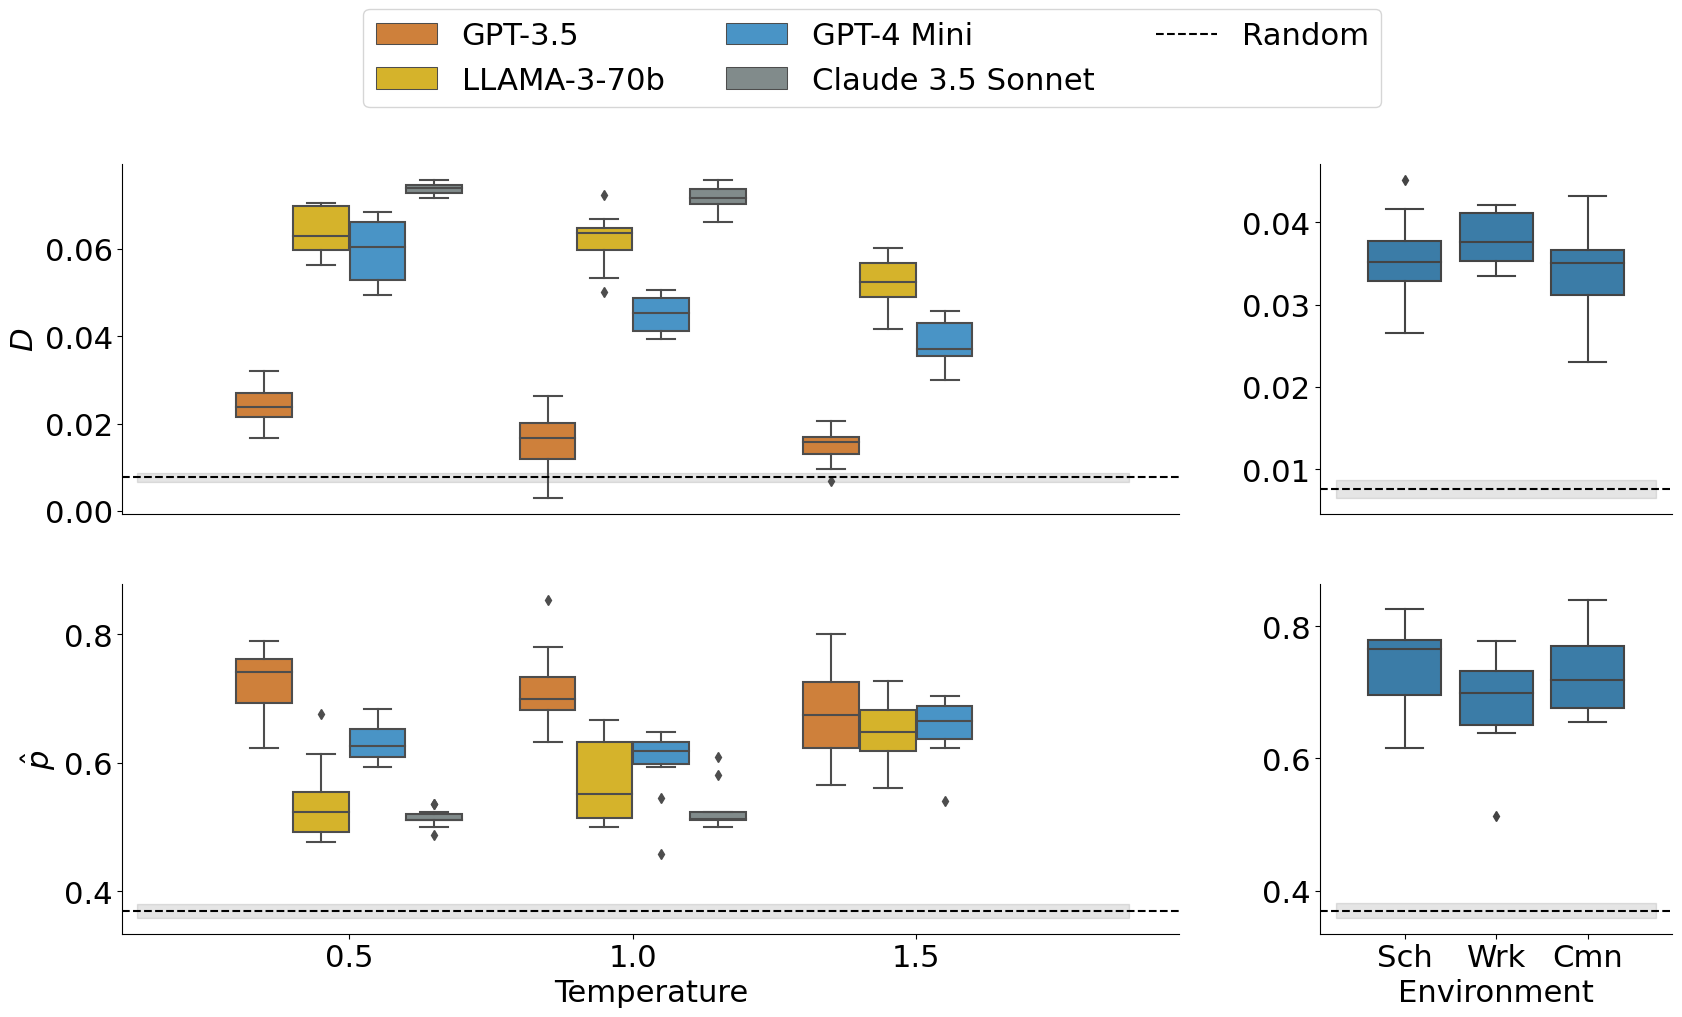

: 

In [2]:
table_outfiles = []
# Other environments
for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_2_neighbors+gpt-3.5-turbo+{environment}.jsonl'
    run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5], environment=environment, role=role, method='llm', num_common_neighbors=False, model='gpt-3.5-turbo')

    table_outfiles.append(outfile)

for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_2_neighbors+{model.replace("/", "-")}.jsonl'
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5, 1.0], method='llm', num_common_neighbors=False, model=model)
    else:
        run_network_formation_experiment(50, 50, 1, 10, outfile, [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False, model=model)

    table_outfiles.append(outfile)

get_table(table_outfiles)

# run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_2_neighbors.jsonl', [0.5, 1.0, 1.5], method='llm', num_common_neighbors=False)
# analyze_experiments('outputs/principle_2_neighbors.jsonl', num_common_neighbors=False)

# run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_2.jsonl', [0.5, 1.0, 1.5], method='llm',  num_common_neighbors=True)
# analyze_experiments('outputs/principle_2.jsonl', num_common_neighbors=True)

In [ ]:
categories = [{'category': 'Mutual Friends', 'description': 'Reasons related to having many friends in common with the person, so the person can introduce them to their friends'}, 
              {'category': 'Well-Connected', 'description': 'Reasons related to the person being well-connected and having many friends'}]

summarize_reasons('outputs/principle_2_neighbors.jsonl', outfile=f'figures/principle_2/principle_2_reasons_neighbors.png', categories=categories)